In [1]:
import numpy as np
import torch
from torchvision import datasets, transforms
import copy
import collections
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
# def noniid(dataset, num_users):
#     """
#     Sample non-I.I.D client data from dataset
#     -> Different clients can hold vastly different amounts of data
#     :param dataset:
#     :param num_users:
#     :return:
#     """
#     num_dataset = len(dataset)
#     idx = np.arange(num_dataset) # create a range from 0 -> dataset length
#     dict_users = {i: list() for i in range(num_users)}
    
#     min_num = int(num_dataset*0.1 / num_users)
#     max_num = int(num_dataset*0.9 / num_users)

#     random_num_size = np.random.randint(min_num, max_num+1, size=num_users) # genreate a random size for each user between min/max
#     print(f"Total number of datasets owned by clients : {sum(random_num_size)}")

#     # total dataset should be larger or equal to sum of splitted dataset.
#     assert num_dataset >= sum(random_num_size)

#     # divide and assign
#     for i, rand_num in enumerate(random_num_size):

#         rand_set = set(np.random.choice(idx, rand_num, replace=False))
#         idx = list(set(idx) - rand_set)
#         dict_users[i] = rand_set

#     return dict_users


In [3]:
def noniid(dataset, num_users,num_classes):
    """
    Sample non-I.I.D client data from dataset
    """
    class_size = 6000

    
    dict_users = {i: list() for i in range(10)}
    min_num = int(class_size*0.1 / num_users)
    max_num = int(class_size*0.9 / num_users)
    print(min_num,max_num)

    for i, worker in enumerate(dict_users):
        rand_set = []
        for j in range(num_classes):
            chosen= np.random.choice([min_num,max_num])
            if chosen == min_num:
                smallest = 0
            else:
                smallest = min_num+1
            rand_number = np.random.randint(smallest,chosen)
            # print(rand_number)
            rand_set.append(rand_number)
        print(rand_set)
        dict_users[i] = rand_set

    print(dict_users)
    return dict_users

In [4]:
def train_dg_split(dataset, num_classes, num_users): 
    dg_idx = []
    train_idx = []
    idxs = np.arange(len(dataset))
    labels = np.array(dataset.targets)

    choice_size = int(len(dataset)*0.2/num_users)
    idxs_labels = np.vstack((idxs, labels))
    idxs_labels = idxs_labels[:,idxs_labels[1,:].argsort()]
    
    idxs = idxs_labels[0]
    labels = idxs_labels[1]
    
    for i in range(num_classes):
        specific_class = np.extract(labels == i, idxs)
        
        dg = np.random.choice(specific_class,choice_size, replace=False)
        print(dg.shape)
        
        train_tmp = set(specific_class)-set(dg)
        
        dg_idx = dg_idx + list(dg)
        
        train_idx = train_idx + list(train_tmp)
    
    return dg_idx, train_idx

In [76]:
if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
dev = torch.device(dev)

num_users = 10
num_classes = 10
trans_cifar = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = datasets.CIFAR10('../data/cifar', train=True, download=True, transform=trans_cifar)

dataset_test = datasets.CIFAR10('../data/cifar', train=False, download=True, transform=trans_cifar)
print(len(dataset),len(dataset_test))

Files already downloaded and verified
Files already downloaded and verified
50000 10000


In [77]:
dg = copy.deepcopy(dataset)
dataset_train = copy.deepcopy(dataset)

dg_idx, dataset_train_idx = train_dg_split(dataset, num_classes,num_users)

dg.targets.clear()
dataset_train.targets.clear()

(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)


In [78]:
dg.data = dataset.data[dg_idx]
dataset_train.data = dataset.data[dataset_train_idx]
print((len(dataset)))
print (len(dg_idx))
print (len(dataset_train_idx))

50000
10000
40000


In [79]:
for i in list(dg_idx):
    dg.targets.append(dataset[i][1])
for i in list(dataset_train_idx):
    dataset_train.targets.append(dataset[i][1])

In [80]:
dict_users = noniid(dataset_train, num_users,num_classes)

60 540
[2, 48, 472, 49, 53, 246, 416, 31, 82, 405]
[23, 333, 174, 361, 37, 341, 427, 337, 20, 57]
[22, 2, 125, 288, 59, 225, 177, 6, 6, 50]
[7, 360, 43, 173, 398, 461, 422, 51, 383, 435]
[51, 437, 0, 292, 428, 351, 235, 54, 23, 197]
[0, 44, 483, 481, 377, 47, 393, 509, 19, 32]
[449, 52, 45, 518, 397, 27, 0, 425, 16, 46]
[276, 243, 413, 301, 40, 41, 425, 466, 19, 436]
[119, 37, 168, 6, 337, 263, 31, 319, 308, 217]
[520, 467, 325, 518, 31, 472, 74, 300, 19, 32]
{0: [2, 48, 472, 49, 53, 246, 416, 31, 82, 405], 1: [23, 333, 174, 361, 37, 341, 427, 337, 20, 57], 2: [22, 2, 125, 288, 59, 225, 177, 6, 6, 50], 3: [7, 360, 43, 173, 398, 461, 422, 51, 383, 435], 4: [51, 437, 0, 292, 428, 351, 235, 54, 23, 197], 5: [0, 44, 483, 481, 377, 47, 393, 509, 19, 32], 6: [449, 52, 45, 518, 397, 27, 0, 425, 16, 46], 7: [276, 243, 413, 301, 40, 41, 425, 466, 19, 436], 8: [119, 37, 168, 6, 337, 263, 31, 319, 308, 217], 9: [520, 467, 325, 518, 31, 472, 74, 300, 19, 32]}


In [100]:
def getDist(y,user_num):
   
    ax = sns.barplot(x=[i for i in range(len(y))],y=y)
    ax.set(title="Count of data classes for %s" %user_num)
    plt.show()

worker 0 data count: 1804
[2, 48, 472, 49, 53, 246, 416, 31, 82, 405]


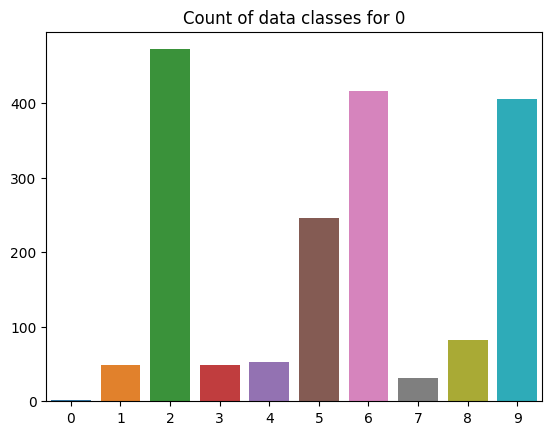

worker 1 data count: 2110
[23, 333, 174, 361, 37, 341, 427, 337, 20, 57]


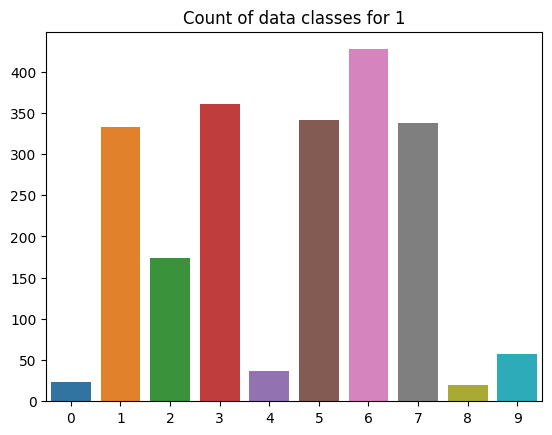

worker 2 data count: 960
[22, 2, 125, 288, 59, 225, 177, 6, 6, 50]


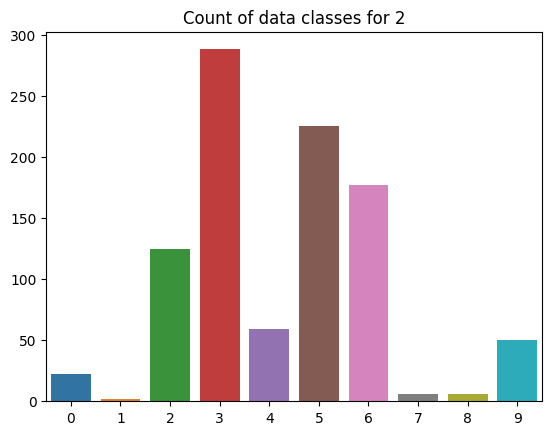

worker 3 data count: 2733
[7, 360, 43, 173, 398, 461, 422, 51, 383, 435]


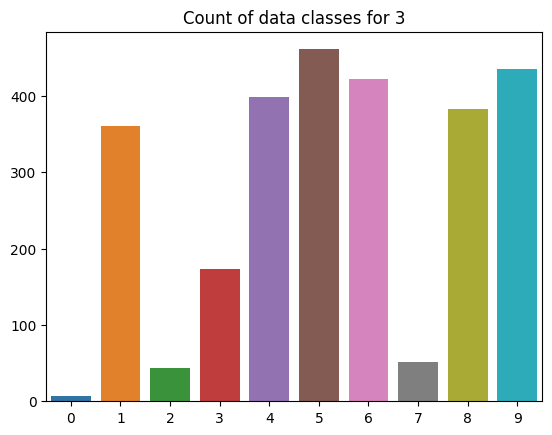

worker 4 data count: 2068
[51, 437, 0, 292, 428, 351, 235, 54, 23, 197]


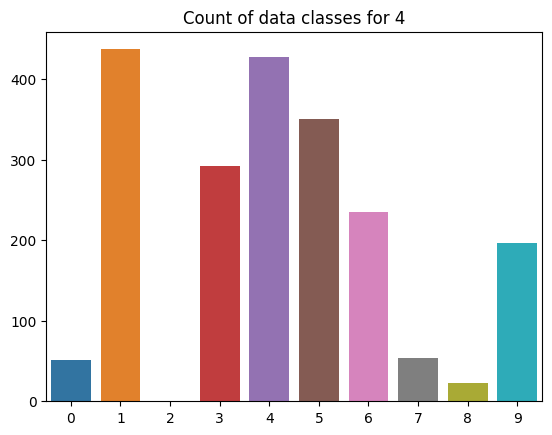

worker 5 data count: 2385
[0, 44, 483, 481, 377, 47, 393, 509, 19, 32]


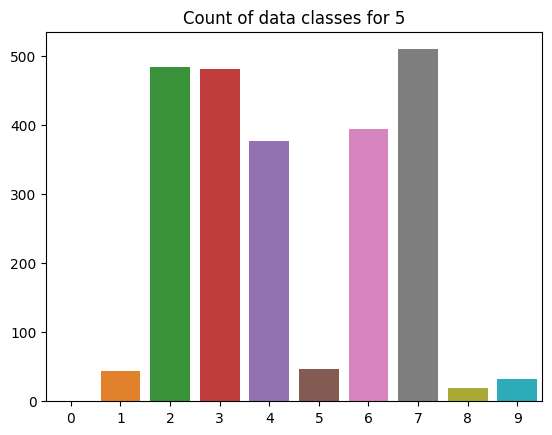

worker 6 data count: 1975
[449, 52, 45, 518, 397, 27, 0, 425, 16, 46]


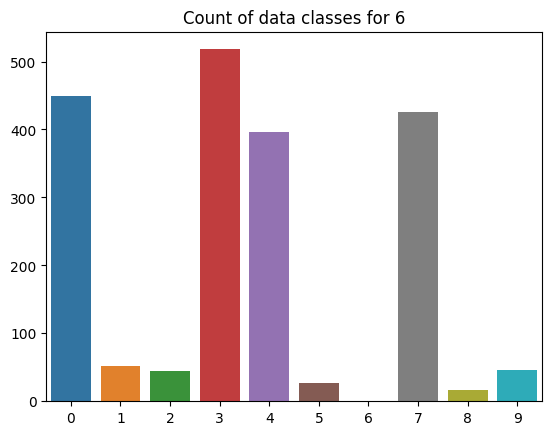

worker 7 data count: 2660
[276, 243, 413, 301, 40, 41, 425, 466, 19, 436]


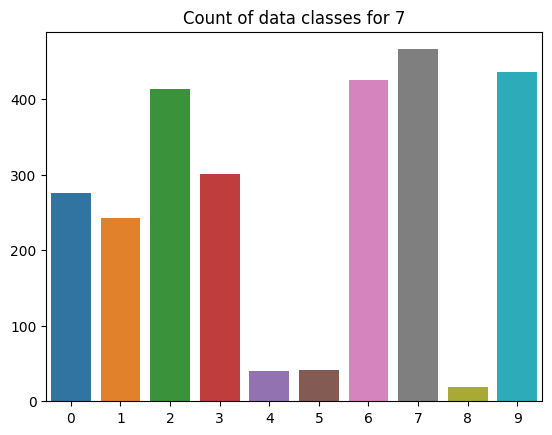

worker 8 data count: 1805
[119, 37, 168, 6, 337, 263, 31, 319, 308, 217]


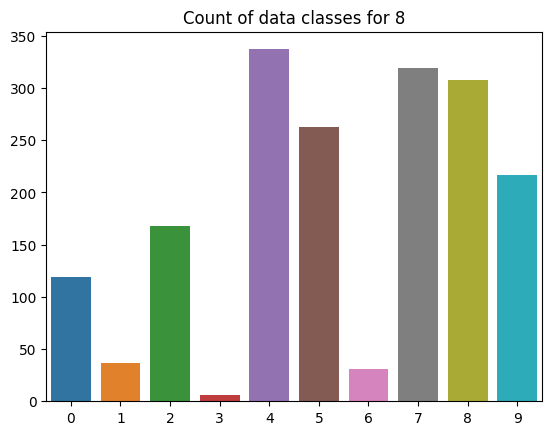

worker 9 data count: 2758
[520, 467, 325, 518, 31, 472, 74, 300, 19, 32]


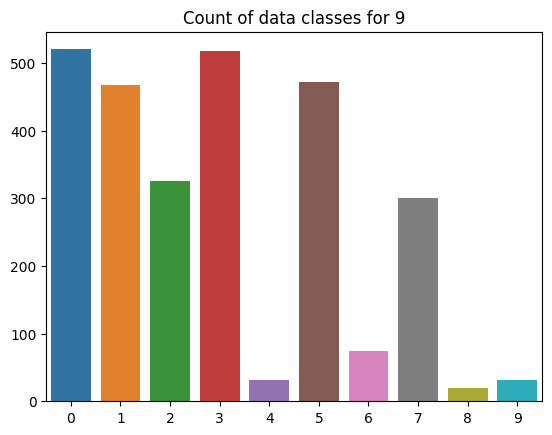

In [101]:
total = 0
target_np = np.asarray(dataset_train.targets)
num_dataset = len(dataset_train)
idx = np.arange(num_dataset)
user_database = {i: list() for i in range(10)}
used = []
# for loop to go through all the users
for i in range (len(dict_users)):
    leng = sum(dict_users[i])
    total += leng
    print('worker', i, 'data count:',leng)
    print(dict_users[i])
    # for loop to go through all the classes for each user
    for j, class_counter in enumerate(dict_users[i]):
        # print(class_counter)
        class_indices = list(np.where(target_np == j)[0]) # dataset labels with current class
        class_indices = list(set(class_indices) - set(used))
        
        class_set = set(np.random.choice(class_indices, class_counter, replace=False))
        used += class_set
        # print('used length:',len(used))
        user_database[i] += class_set
    getDist(dict_users[i],i)

In [105]:
print(len(user_database[0]))
# for i in user_database[0]:
#     print(dataset_train.targets[i])
targets = [dataset_train.targets[i] for i in user_database[0]]
print(targets)

1804
[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2